In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import pandas as pd
import copy

from sklearn.metrics import roc_curve , roc_auc_score , precision_recall_curve

pd.options.display.max_rows = 200

# Import Models and Test Data

In [47]:
rf = pickle.load(open('rf_final.p','rb'))
gb = pickle.load(open('gb_final.p','rb'))
logit= pickle.load(open('logRegModel.p','rb'))
vote_soft = pickle.load(open('voting_classifer_soft.p','rb'))

In [48]:
X_val = pickle.load(open('X_val_processed.p','rb'))
y_val = pickle.load(open('y_val.p','rb'))
X_test = pickle.load(open('X_test_processed.p','rb'))
y_test = pickle.load(open('y_test.p','rb'))


In [49]:
y_val.shape

(1069,)

# Build a ROC curve

In [50]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val,rf.predict_proba(X_val)[:,1])
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_val,gb.predict_proba(X_val)[:,1])
logit_fpr, logit_tpr, logit_thresholds = roc_curve(y_val,logit.predict_proba(X_val)[:,1])
vote_soft_fpr, vote_soft_tpr, vote_soft_thresholds = roc_curve(y_val,vote_soft.predict_proba(X_val)[:,1])



roc_auc_rf = roc_auc_score(y_val,rf.predict_proba(X_val)[:,1])
roc_auc_gb = roc_auc_score(y_val,gb.predict_proba(X_val)[:,1])
roc_auc_logistic = roc_auc_score(y_val,logit.predict_proba(X_val)[:,1])
roc_auc_vote_soft = roc_auc_score(y_val,vote_soft.predict_proba(X_val)[:,1])



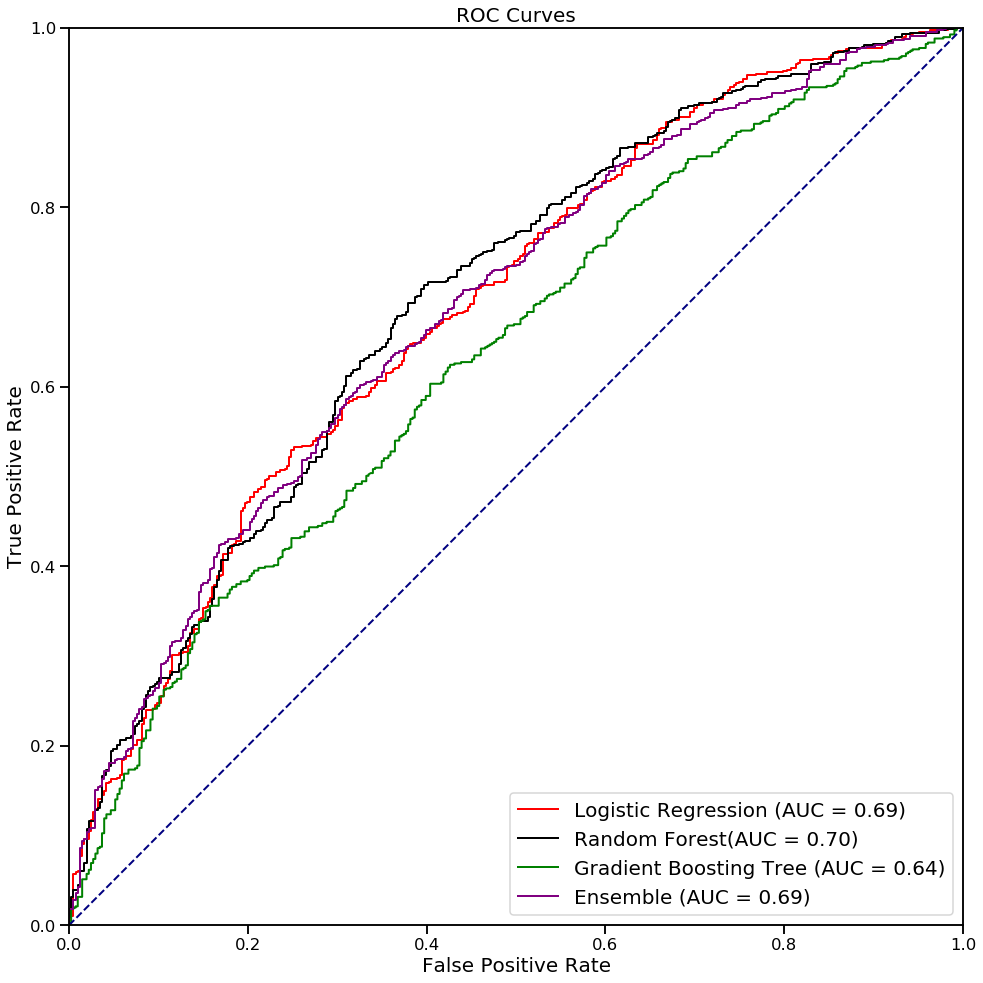

In [51]:
sns.set_context("talk")
fig = plt.figure(figsize=(14,14))
lw = 2


plt.plot(logit_fpr, logit_tpr, color='red',
         lw=lw, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logistic)
plt.plot(rf_fpr, rf_tpr, color='black',
         lw=lw, label='Random Forest(AUC = %0.2f)' % roc_auc_rf)
plt.plot(gb_fpr, gb_tpr, color='green',
         lw=lw, label='Gradient Boosting Tree (AUC = %0.2f)' % roc_auc_gb)
plt.plot(vote_soft_fpr,vote_soft_tpr, color='purple',
         lw=lw, label='Ensemble (AUC = %0.2f)' % roc_auc_vote_soft)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('ROC Curves', fontsize = 20)
plt.legend(loc="lower right", fontsize = 20)
plt.tight_layout()
# plt.savefig('roc_curves_all_ALL.png')
# plt.savefig('roc_curves_svg_all_all.svg')
plt.show()

# Build a PR curve

In [52]:
rf_percision, rf_recall, rf_thresholds = precision_recall_curve(y_val,rf.predict_proba(X_val)[:,1])
gb_percision, gb_recall, gb_thresholds = precision_recall_curve(y_val,gb.predict_proba(X_val)[:,1])
logit_percision, logit_recall, logit_thresholds = precision_recall_curve(y_val,logit.predict_proba(X_val)[:,1])
vote_soft_percision, vote_soft_recall, vote_soft_thresholds = precision_recall_curve(y_val,vote_soft.predict_proba(X_val)[:,1])




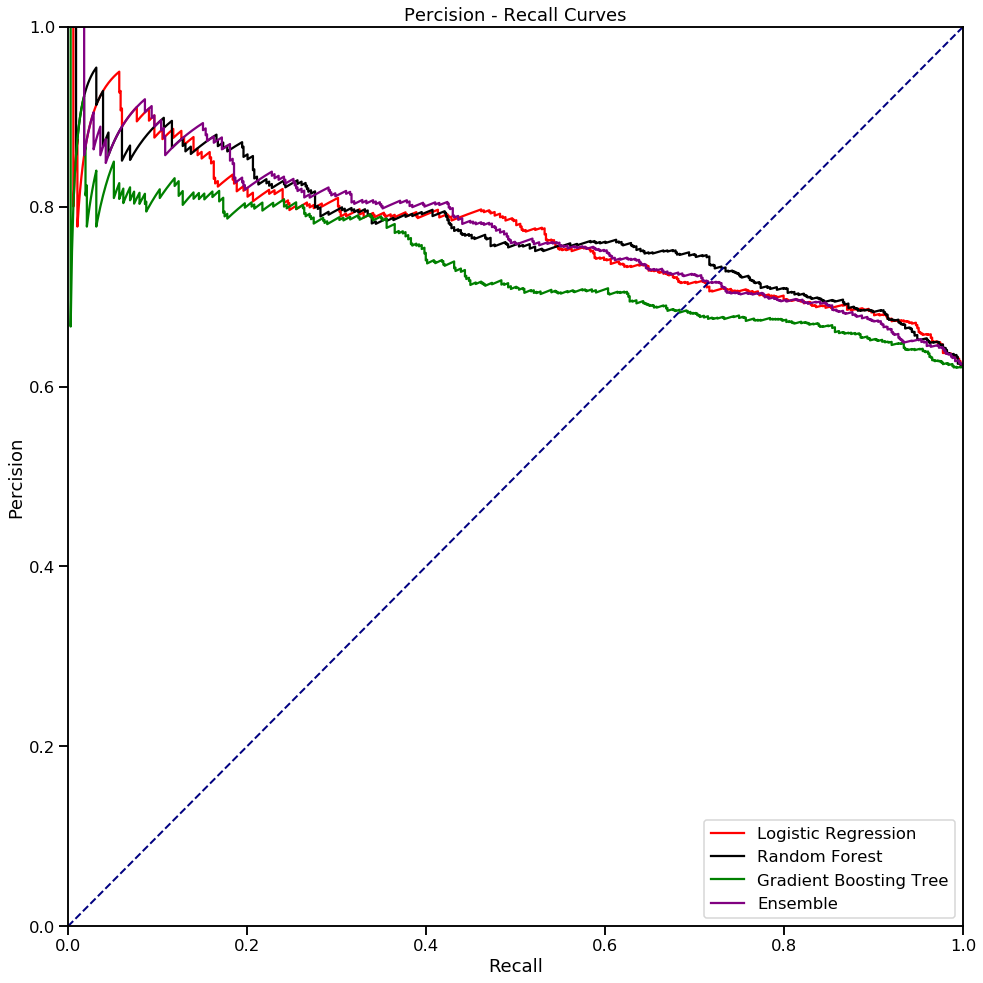

In [53]:
sns.set_context('talk')
fig = plt.figure(figsize=(14,14))



plt.plot( logit_recall,logit_percision, color='red',
          label='Logistic Regression')
plt.plot( rf_recall,rf_percision, color='black',
          label='Random Forest')
plt.plot( gb_recall,gb_percision, color='green',
          label='Gradient Boosting Tree')
plt.plot( vote_soft_recall,vote_soft_percision, color='purple',
          label='Ensemble')



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Percision')
plt.title('Percision - Recall Curves')
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig('roc_curves_all_ALL.png')
# plt.savefig('roc_curves_svg_all_all.svg')
plt.show()

# Threshold Tuning 

In [54]:
threshold_tuner = pd.DataFrame({
    'y_val':y_val,
    'rf_prob':rf.predict_proba(X_val)[:,1],
    'gb_prob':gb.predict_proba(X_val)[:,1],
    'logit_prob':logit.predict_proba(X_val)[:,1],
    'ensemble_prob':vote_soft.predict_proba(X_val)[:,1]
})

In [55]:
threshold_tuner['threshold'] = 0 
threshold_tuner_exploded = pd.DataFrame(columns = threshold_tuner.columns)


for n in range(101):
    threshold_tuner['threshold'] = n/100
    threshold_tuner_exploded=threshold_tuner_exploded.append(threshold_tuner,ignore_index=True)

In [56]:

threshold_tuner_exploded['rf_fp'] = 0
threshold_tuner_exploded['rf_fn'] = 0



threshold_tuner_exploded['gb_fp'] = 0
threshold_tuner_exploded['gb_fn'] = 0



threshold_tuner_exploded['logit_fp'] = 0
threshold_tuner_exploded['logit_fn'] = 0



threshold_tuner_exploded['ensemble_fp'] = 0
threshold_tuner_exploded['ensemble_fn'] = 0


In [57]:
threshold_tuner_exploded.sample(20)

,y_val,rf_prob,gb_prob,logit_prob,ensemble_prob,threshold,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn
105827,1,0.672525,0.999889,0.628402,0.756547,0.98,0,0,0,0,0,0,0,0
24881,1,0.597824,0.998136,0.532580,0.691543,0.23,0,0,0,0,0,0,0,0
102784,1,0.634780,0.246004,0.587919,0.615744,0.96,0,0,0,0,0,0,0,0
17224,0,0.631331,0.621505,0.533639,0.717753,0.16,0,0,0,0,0,0,0,0
72579,1,0.607728,0.048541,0.803967,0.532792,0.67,0,0,0,0,0,0,0,0
88544,1,0.646335,0.995506,0.774043,0.805580,0.82,0,0,0,0,0,0,0,0
64147,1,0.645475,0.910891,0.962485,0.870405,0.60,0,0,0,0,0,0,0,0
3770,1,0.708602,0.999591,0.872857,0.861098,0.03,0,0,0,0,0,0,0,0
12737,1,0.653363,0.994916,0.753363,0.806007,0.11,0,0,0,0,0,0,0,0
22092,1,0.584813,0.922957,0.718962,0.733264,0.20,0,0,0,0,0,0,0,0


In [58]:
tte=copy.deepcopy(threshold_tuner_exploded)

In [59]:
tte.loc[(tte.rf_prob>tte.threshold) & tte.y_val==0, 'rf_fp'] = int(1)
tte.loc[(tte.gb_prob>tte.threshold) & tte.y_val==0, 'gb_fp'] = int(1)
tte.loc[(tte.logit_prob>tte.threshold) & tte.y_val==0, 'logit_fp'] = int(1)
tte.loc[(tte.ensemble_prob>tte.threshold) & tte.y_val==0, 'ensemble_fp'] = int(1)

tte.loc[(tte.rf_prob<tte.threshold) & tte.y_val==1, 'rf_fn'] = int(1)
tte.loc[(tte.gb_prob<tte.threshold) & tte.y_val==1, 'gb_fn'] = int(1)
tte.loc[(tte.logit_prob<tte.threshold) & tte.y_val==1, 'logit_fn'] = int(1)
tte.loc[(tte.ensemble_prob<tte.threshold) & tte.y_val==1, 'ensemble_fn'] = int(1)

In [60]:
tte.head()

,y_val,rf_prob,gb_prob,logit_prob,ensemble_prob,threshold,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn
0,1,0.612254,0.910298,0.728733,0.577336,0.0,0,0,0,0,0,0,0,0
1,1,0.677646,0.365279,0.787282,0.772959,0.0,0,0,0,0,0,0,0,0
2,1,0.641392,0.987998,0.777093,0.816667,0.0,0,0,0,0,0,0,0,0
3,0,0.542042,0.008091,0.305853,0.349071,0.0,1,0,1,0,1,0,1,0
4,1,0.640004,0.478954,0.469313,0.670478,0.0,0,0,0,0,0,0,0,0


In [61]:
tte['rf_cost'] = tte['rf_fp'] * 150000/2 + tte['rf_fn']*8000
tte['gb_cost'] = tte['gb_fp'] * 150000/2 + tte['gb_fn']*8000
tte['ensemble_cost'] = tte['ensemble_fp'] * 150000/2 + tte['ensemble_fn']*8000
tte['logit_cost'] = tte['logit_fp'] * 150000/2 + tte['logit_fn']*8000

In [62]:
tte.groupby(by= 'threshold').sum().sort_values(by= 'ensemble_cost', ascending = True)

,rf_prob,gb_prob,logit_prob,ensemble_prob,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn,rf_cost,gb_cost,ensemble_cost,logit_cost
threshold,,,,,,,,,,,,,,,,
0.00,660.333253,711.825544,666.72282,690.509921,406,0,406,0,406,0,406,0,30450000.0,30450000.0,30450000.0,30450000.0
0.20,660.333253,711.825544,666.72282,690.509921,406,0,521,115,409,3,406,0,30450000.0,39995000.0,30450000.0,30699000.0
0.19,660.333253,711.825544,666.72282,690.509921,406,0,520,114,409,3,406,0,30450000.0,39912000.0,30450000.0,30699000.0
0.18,660.333253,711.825544,666.72282,690.509921,406,0,515,109,408,2,406,0,30450000.0,39497000.0,30450000.0,30616000.0
0.17,660.333253,711.825544,666.72282,690.509921,406,0,514,108,408,2,406,0,30450000.0,39414000.0,30450000.0,30616000.0
0.16,660.333253,711.825544,666.72282,690.509921,406,0,513,107,408,2,406,0,30450000.0,39331000.0,30450000.0,30616000.0
0.15,660.333253,711.825544,666.72282,690.509921,406,0,512,106,408,2,406,0,30450000.0,39248000.0,30450000.0,30616000.0
0.14,660.333253,711.825544,666.72282,690.509921,406,0,511,105,408,2,406,0,30450000.0,39165000.0,30450000.0,30616000.0
0.13,660.333253,711.825544,666.72282,690.509921,406,0,506,100,407,1,406,0,30450000.0,38750000.0,30450000.0,30533000.0


In [64]:
tte.groupby(by= 'threshold').sum().sort_values(by= 'rf_cost', ascending = True)

,rf_prob,gb_prob,logit_prob,ensemble_prob,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn,rf_cost,gb_cost,ensemble_cost,logit_cost
threshold,,,,,,,,,,,,,,,,
0.00,660.333253,711.825544,666.72282,690.509921,406,0,406,0,406,0,406,0,30450000.0,30450000.0,30450000.0,30450000.0
0.25,660.333253,711.825544,666.72282,690.509921,406,0,536,130,415,9,412,6,30450000.0,41240000.0,30948000.0,31197000.0
0.26,660.333253,711.825544,666.72282,690.509921,406,0,538,132,417,11,415,9,30450000.0,41406000.0,31197000.0,31363000.0
0.27,660.333253,711.825544,666.72282,690.509921,406,0,540,134,421,15,418,12,30450000.0,41572000.0,31446000.0,31695000.0
0.28,660.333253,711.825544,666.72282,690.509921,406,0,542,136,421,15,419,13,30450000.0,41738000.0,31529000.0,31695000.0
0.29,660.333253,711.825544,666.72282,690.509921,406,0,542,136,421,15,422,16,30450000.0,41738000.0,31778000.0,31695000.0
0.30,660.333253,711.825544,666.72282,690.509921,406,0,543,137,423,17,426,20,30450000.0,41821000.0,32110000.0,31861000.0
0.31,660.333253,711.825544,666.72282,690.509921,406,0,543,137,423,17,433,27,30450000.0,41821000.0,32691000.0,31861000.0
0.32,660.333253,711.825544,666.72282,690.509921,406,0,545,139,427,21,437,31,30450000.0,41987000.0,33023000.0,32193000.0
